In [1]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

# VGG19 Architecture
<img src='https://drive.google.com/uc?export=view&id=1E_wd512CHVDolpZtffJGVvWHY9usk7a0' width='70%'/>


# Load in VGG19 features:
VGG19 is split into two portions:

* vgg19.features, which are all the convolutional and pooling layers
vgg19.classifier, which are the three linear, classifier layers at the end
* We only need the features portion, which we're going to load in and "freeze" the weights of, below.

In [2]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

vgg.to(device)

cuda


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [6]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert("RGB")

    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape
    in_transform = transforms.Compose(
        [
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    )
    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3, :, :].unsqueeze(0)
    return image

In [8]:
content = load_image("images/hoovertowernight.jpg").to(device)
style = load_image("images/candy.jpg", shape=content.shape[-2:]).to(device)

In [9]:
def im_convert(tensor):

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)

    # Multiply std and add mean to get back the original image
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))

    # for all val in image: val=min((max(0,val)),1)
    image = image.clip(0, 1)
    return image

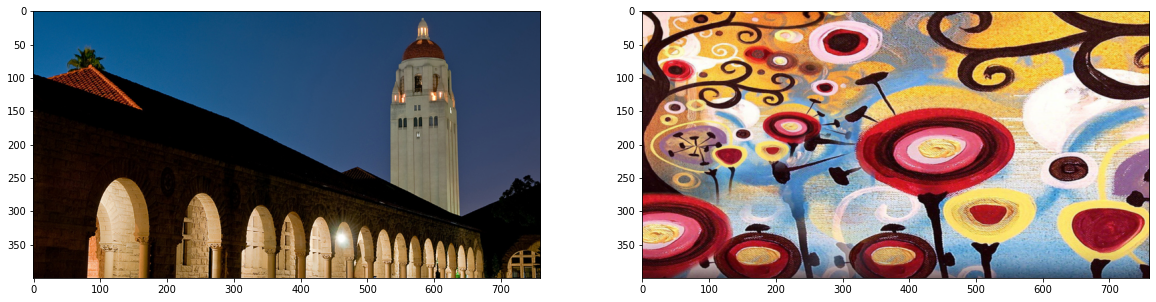

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [11]:
for name, layer in vgg._modules.items():
    print(f"name: {name} \t layer: {layer}")

name: 0 	 layer: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
name: 1 	 layer: ReLU(inplace=True)
name: 2 	 layer: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
name: 3 	 layer: ReLU(inplace=True)
name: 4 	 layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
name: 5 	 layer: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
name: 6 	 layer: ReLU(inplace=True)
name: 7 	 layer: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
name: 8 	 layer: ReLU(inplace=True)
name: 9 	 layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
name: 10 	 layer: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
name: 11 	 layer: ReLU(inplace=True)
name: 12 	 layer: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
name: 13 	 layer: ReLU(inplace=True)
name: 14 	 layer: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
name: 

In [12]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {
            "0": "conv1_1",
            "5": "conv2_1",
            "10": "conv3_1",
            "19": "conv4_1",
            "21": "conv4_2",  ## content representation
            "28": "conv5_1",
        }

    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

In [13]:
def gram_matrix(tensor):

    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()

    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())

    return gram

In [14]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

In [20]:
style_weights = {
    "conv1_1": 0.2,
    "conv2_1": 0.2,
    "conv3_1": 0.2,
    "conv4_1": 0.2,
    "conv5_1": 0.2,
}

alpha = 1e3
beta = 1e10

Total loss:  10437659648.0


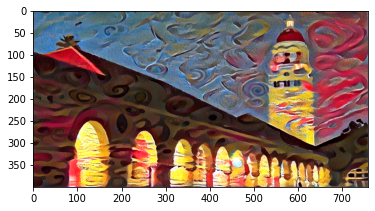

Total loss:  6364126720.0


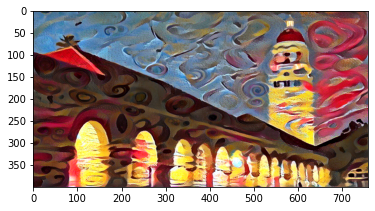

Total loss:  4368844800.0


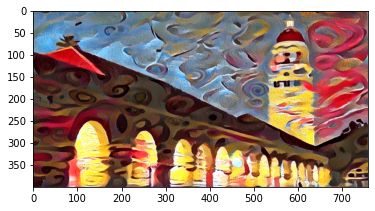

Total loss:  3355874304.0


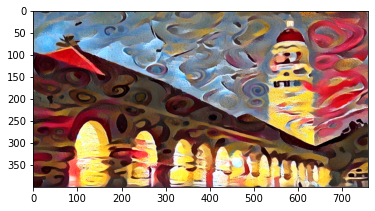

Total loss:  2808749312.0


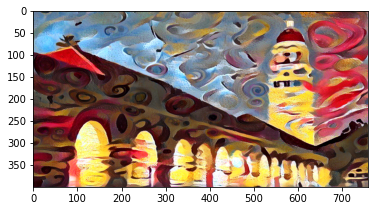

In [21]:
show_every = 800
optimizer = optim.Adam([target], lr=0.001)
steps = 4000

for ii in range(1, steps + 1):
    target_features = get_features(target, vgg)

    content_loss = torch.mean(
        (target_features["conv4_2"] - content_features["conv4_2"]) ** 2
    )
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean(
            (target_gram - style_gram) ** 2
        )
        style_loss += layer_style_loss / (d * h * w)

    total_loss = alpha * content_loss + beta * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if ii % show_every == 0:
        print("Total loss: ", total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

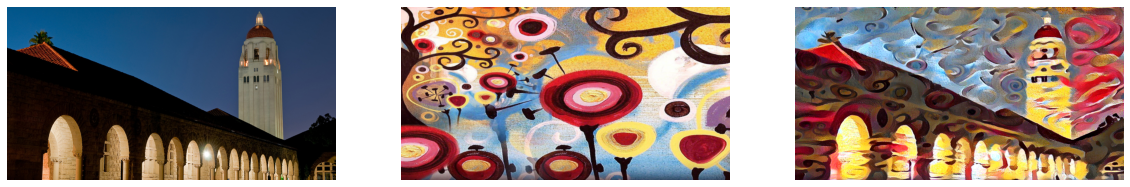

In [32]:
fig, (ax) = plt.subplots(1, 3, figsize=(20, 15))
for i in range(3):
    ax[i].set_axis_off()
ax[0].imshow(im_convert(content))
ax[1].imshow(im_convert(style))
ax[2].imshow(im_convert(target))